# Wind prediction

In this project, I built a neural network to predict Wind direction starting from some meteo variables.

In [113]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load and prepare the data

In [114]:
data_path = 'data/jena_climate_2009_2016.csv'
meteo = pd.read_csv(data_path)

meteo.columns = meteo.columns.str.replace(' ','')
meteo['date']=pd.to_datetime(meteo['DateTime'])
data=meteo

## Checking out the data

This dataset has meteo data for each 10 min of each day from 2009 to 2017. 

Below is a plot showing the Wind degrees over the first 100 days or so in the data set.

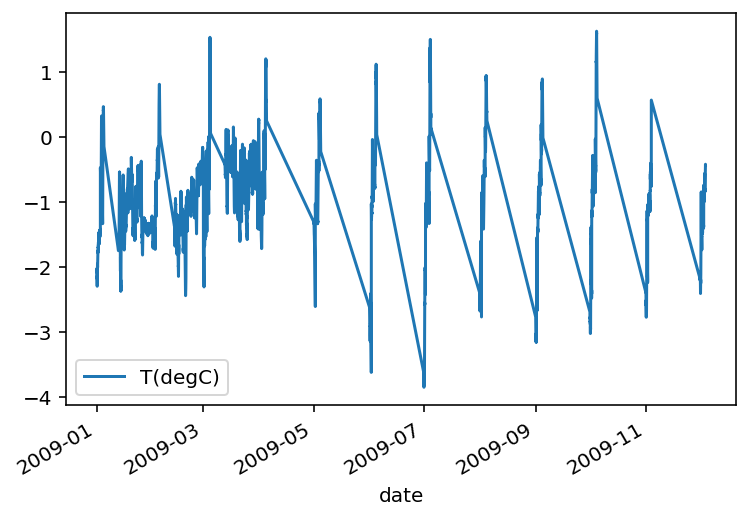

In [130]:
meteo[:24*100*6].plot(x='date', y='T(degC)')

### Scaling target variables
To make training the network easier, we'll standardize each of the continuous variables. That is, we'll shift and scale the variables such that they have zero mean and a standard deviation of 1.

The scaling factors are saved so we can go backwards when we use the network for predictions.

In [116]:
meteo.columns

Index(['DateTime', 'p(mbar)', 'T(degC)', 'Tpot(K)', 'Tdew(degC)', 'rh(%)',
       'VPmax(mbar)', 'VPact(mbar)', 'VPdef(mbar)', 'sh(g/kg)',
       'H2OC(mmol/mol)', 'rho(g/m**3)', 'wv(m/s)', 'max.wv(m/s)', 'wd(deg)',
       'date'],
      dtype='object')

In [117]:
quant_features = ['p(mbar)', 'T(degC)', 'Tpot(K)', 'Tdew(degC)', 'rh(%)',
       'VPmax(mbar)', 'VPact(mbar)', 'VPdef(mbar)', 'sh(g/kg)',
       'H2OC(mmol/mol)', 'rho(g/m**3)', 'wv(m/s)', 'max.wv(m/s)', 'wd(deg)']
# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std

# Splitting the data into training, testing, and validation sets

We'll save the data for the last 1 year to use as a test set after we've trained the network. We'll use this set to make predictions and compare them with the actual number of riders.

In [131]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 367991 entries, 0 to 367990
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   p(mbar)         367991 non-null  float64
 1   T(degC)         367991 non-null  float64
 2   Tpot(K)         367991 non-null  float64
 3   Tdew(degC)      367991 non-null  float64
 4   rh(%)           367991 non-null  float64
 5   VPmax(mbar)     367991 non-null  float64
 6   VPact(mbar)     367991 non-null  float64
 7   VPdef(mbar)     367991 non-null  float64
 8   sh(g/kg)        367991 non-null  float64
 9   H2OC(mmol/mol)  367991 non-null  float64
 10  rho(g/m**3)     367991 non-null  float64
 11  wv(m/s)         367991 non-null  float64
 12  max.wv(m/s)     367991 non-null  float64
 13  wd(deg)         367991 non-null  float64
dtypes: float64(14)
memory usage: 39.3 MB


In [132]:
fields_to_drop = ['DateTime','date']
data = meteo.drop(fields_to_drop, axis=1)
#data.head()

In [133]:
# Save data for approximately the last 21 days 
test_data = data[-365*24*6:]

# Now remove the test data from the data set 
data = data[:-365*24*6]

# Separate the data into features and targets
target_fields = ['T(degC)']
features, targets = data.drop(target_fields, axis=1), data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

We'll split the data into two sets, one for training and one for validating as the network is being trained. Since this is time series data, we'll train on historical data, then try to predict on future data (the validation set).

In [134]:
# Hold out the last 60 days or so of the remaining data as a validation set
train_features, train_targets = features[:-365*24*6], targets[:-365*24*6]
val_features, val_targets = features[-365*24*6:], targets[-365*24*6:]

## The network


<img src="assets/neural_network.png" width=300px>

The network has two layers, a hidden layer and an output layer. The hidden layer will use the sigmoid function for activations. The output layer has only one node and is used for the regression, the output of the node is the same as the input of the node. That is, the activation function is $f(x)=x$. A function that takes the input signal and generates an output signal, but takes into account the threshold, is called an activation function. We work through each layer of our network calculating the outputs for each neuron. All of the outputs from one layer become inputs to the neurons on the next layer. This process is called *forward propagation*.

We use the weights to propagate signals forward from the input to the output layers in a neural network. We use the weights to also propagate error backwards from the output back into the network to update our weights.

In [135]:
from MeteoNet import NeuralNetwork

In [136]:
def MSE(y, Y):
    return np.mean((y-Y)**2)

## Training the network

Here you'll set the hyperparameters for the network. The strategy here is to find hyperparameters such that the error on the training set is low, but you're not overfitting to the data. If you train the network too long or have too many hidden nodes, it can become overly specific to the training set and will fail to generalize to the validation set. That is, the loss on the validation set will start increasing as the training set loss drops.

You'll also be using a method know as Stochastic Gradient Descent (SGD) to train the network. The idea is that for each training pass, you grab a random sample of the data instead of using the whole data set. You use many more training passes than with normal gradient descent, but each pass is much faster. This ends up training the network more efficiently. You'll learn more about SGD later.

### Choose the number of iterations
This is the number of batches of samples from the training data we'll use to train the network. The more iterations you use, the better the model will fit the data. However, this process can have sharply diminishing returns and can waste computational resources if you use too many iterations.  You want to find a number here where the network has a low training loss, and the validation loss is at a minimum. The ideal number of iterations would be a level that stops shortly after the validation loss is no longer decreasing.

### Choose the learning rate
This scales the size of weight updates. If this is too big, the weights tend to explode and the network fails to fit the data. Normally a good choice to start at is 0.1; however, if you effectively divide the learning rate by n_records, try starting out with a learning rate of 1. In either case, if the network has problems fitting the data, try reducing the learning rate. Note that the lower the learning rate, the smaller the steps are in the weight updates and the longer it takes for the neural network to converge.

### Choose the number of hidden nodes
In a model where all the weights are optimized, the more hidden nodes you have, the more accurate the predictions of the model will be.  (A fully optimized model could have weights of zero, after all.) However, the more hidden nodes you have, the harder it will be to optimize the weights of the model, and the more likely it will be that suboptimal weights will lead to overfitting. With overfitting, the model will memorize the training data instead of learning the true pattern, and won't generalize well to unseen data.  

Try a few different numbers and see how it affects the performance. You can look at the losses dictionary for a metric of the network performance. If the number of hidden units is too low, then the model won't have enough space to learn and if it is too high there are too many options for the direction that the learning can take. The trick here is to find the right balance in number of hidden units you choose.  You'll generally find that the best number of hidden nodes to use ends up being between the number of input and output nodes.

In [140]:
import sys


from MeteoNet import iterations, learning_rate, hidden_nodes, output_nodes


N_i = train_features.shape[1]
network = NeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate)

losses = {'train':[], 'validation':[]}
for ii in range(iterations):
    # Go through a random batch of 128 records from the training data set
    batch = np.random.choice(train_features.index, size=128)
    X, y = train_features.loc[batch].values, train_targets.loc[batch]['T(degC)']
                             
    network.train(X, y)
    
    # Printing out the training progress
    train_loss = MSE(network.run(train_features).T, train_targets['T(degC)'].values)
    val_loss = MSE(network.run(val_features).T, val_targets['T(degC)'].values)
    sys.stdout.write("\rProgress: {:2.1f}".format(100 * ii/float(iterations)) \
                     + "% ... Training loss: " + str(train_loss)[:5] \
                     + " ... Validation loss: " + str(val_loss)[:5])
    sys.stdout.flush()
    
    losses['train'].append(train_loss)
    losses['validation'].append(val_loss)

Progress: 99.5% ... Training loss: 0.109 ... Validation loss: 0.109

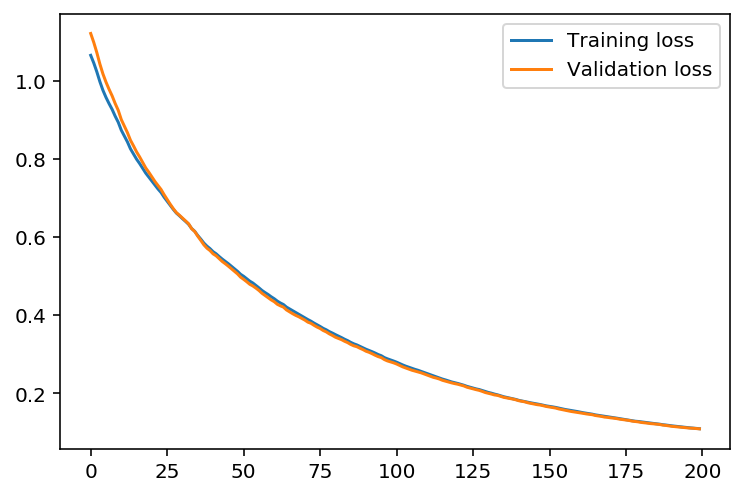

In [141]:
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()
_ = plt.ylim()

## Check out your predictions

Here, use the test data to view how well your network is modeling the data. If something is completely wrong here, make sure each step in your network is implemented correctly.

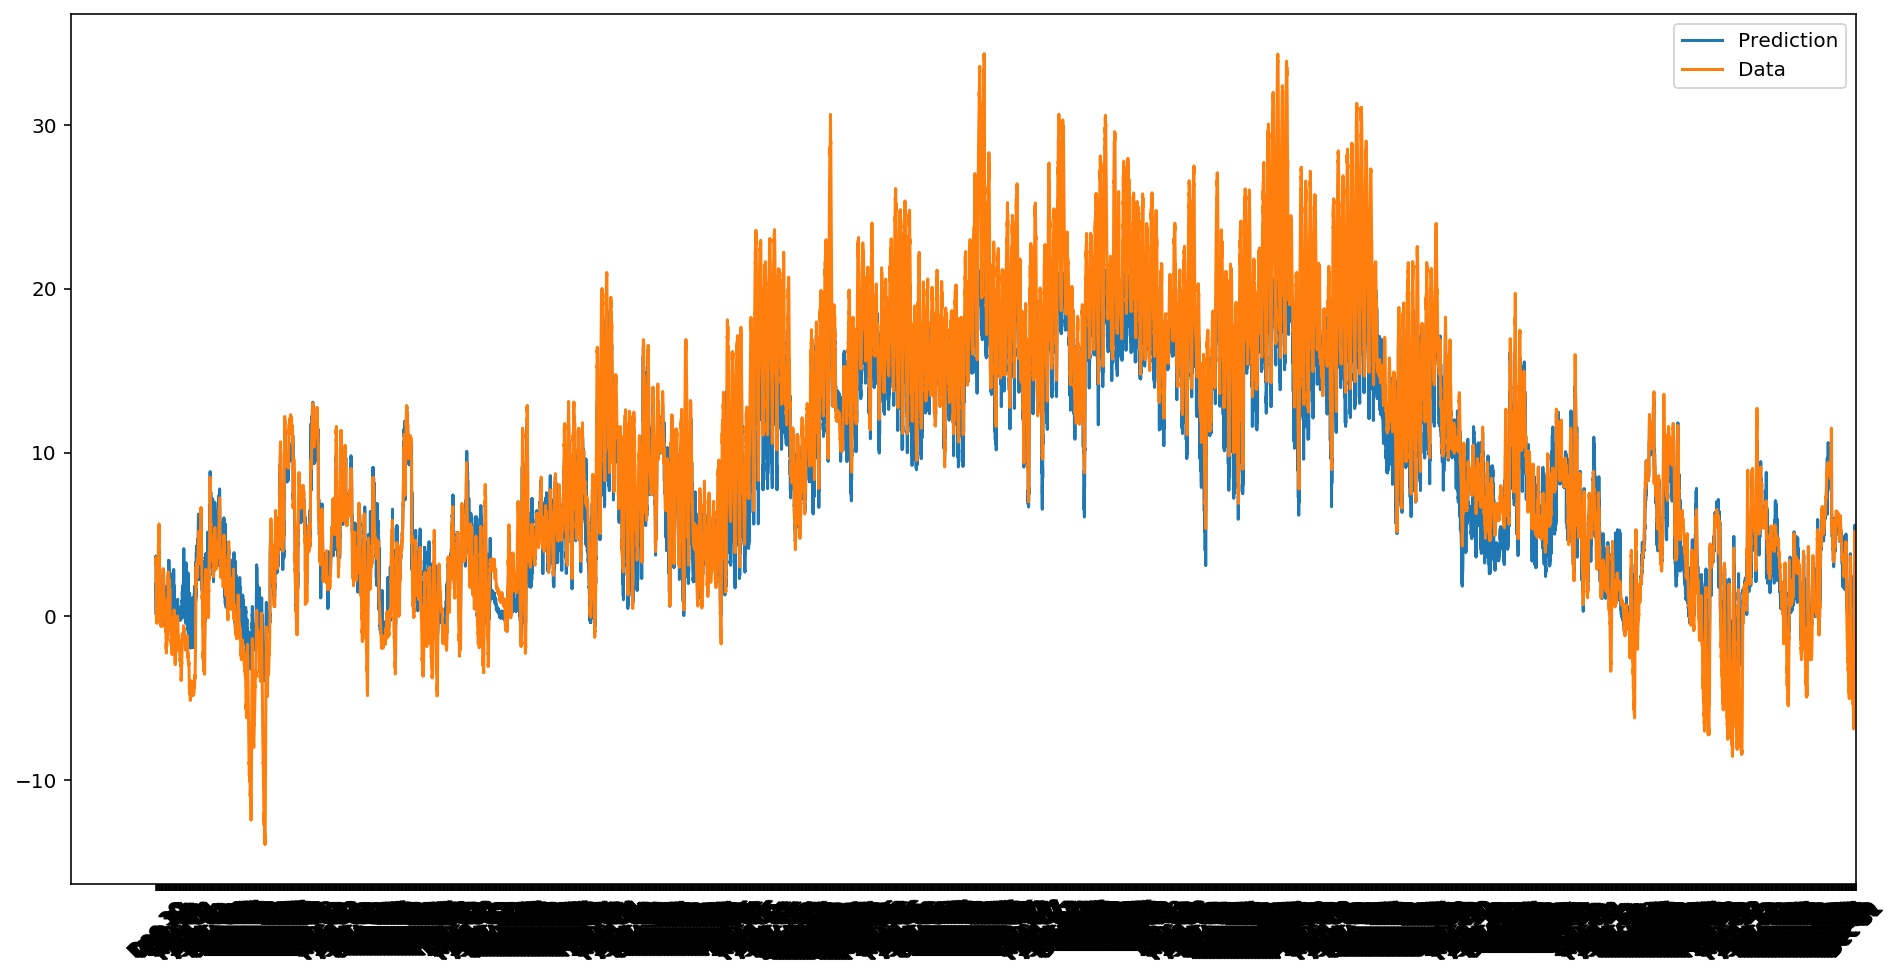

In [142]:
fig, ax = plt.subplots(figsize=(16,8))

mean, std = scaled_features['T(degC)']
predictions = network.run(test_features).T*std + mean
ax.plot(predictions[0], label='Prediction')
ax.plot((test_targets['T(degC)']*std + mean).values, label='Data')
ax.set_xlim(right=len(predictions))
ax.legend()

dates = pd.to_datetime(meteo.loc[test_data.index]['date'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)